<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/04.neural_networks/neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels

import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger



!pip install category_encoders
import category_encoders as ce




# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKeras


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat


# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile

--2020-04-06 17:10:08--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12412 (12K) [text/plain]
Saving to: ‘visualization.py.3’

visualization.py.3  100%[===================>]  12.12K  --.-KB/s    in 0s      

2020-04-06 17:10:08 (43.9 MB/s) - ‘visualization.py.3’ saved [12412/12412]



### Mount your Google Drive

Training a neural network may take long time and you don't want to do it every time. Once you've trained a model, it is better to save it, so that you can use it immediately for prediction next times.

Unfortunately, the storage on Google is reset every time. You need to store all persistent data in you Google Drive.

You need therefore to mount your Google Drive, which you will use later in this notebook

In [76]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/04.neural-networks/'

Mounted at /content/gdrive


# Use case description

The use case is from [KhConf19].


**Goal** Estimate available bandwidth in a network via **passive measures**.

More precisely:
_Estimate the capacity available to a TCP flow_ (sharing links with other flows) observing
* The time gaps between segments sent $g_{\text{in}}$
* The gaps between acks $g_\text{ack}$



![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/ack.png)
\[Figure from [KhThesis19] \]


The auhtors set up the following testbed:


![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/testbed.png)


Measures are collected in the **Video Receiver**. All the other machines just produce cross-traffic.

Measures are recorded via an Endace Data Acquisition and Generation (DAG) card, which timestamp all packets in an extremely precise way.

![alt text](https://www.endace.com/assets/images/products/DAG%209.5G4F_angled_small.png)

([Producer website](https://www.endace.com/endace-high-speed-packet-capture-solutions/oem/dag/))

**Why**: Knowing the available bandwidth, video streaming clients can properly choose the quality level to request.

# Traces

The description of the dataset can be found in the Appendix of Khangura's [PhD thesis](https://www.repo.uni-hannover.de/bitstream/handle/123456789/9219/Khangura_Sukhpreet_PhD_Thesis.pdf?sequence=3&isAllowed=y).

In [77]:
!wget https://www.ikt.uni-hannover.de/fileadmin/institut/Forschung/BandwidthEstimationTraces/BandwidthEstimationTraces.zip

--2020-04-06 17:07:41--  https://www.ikt.uni-hannover.de/fileadmin/institut/Forschung/BandwidthEstimationTraces/BandwidthEstimationTraces.zip
Resolving www.ikt.uni-hannover.de (www.ikt.uni-hannover.de)... 130.75.2.72
Connecting to www.ikt.uni-hannover.de (www.ikt.uni-hannover.de)|130.75.2.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 941822 (920K) [application/zip]
Saving to: ‘BandwidthEstimationTraces.zip.3’

BandwidthEstimation 100%[===================>] 919.75K   399KB/s    in 2.3s    

2020-04-06 17:07:44 (399 KB/s) - ‘BandwidthEstimationTraces.zip.3’ saved [941822/941822]



In [0]:
! unzip -o -q BandwidthEstimationTraces.zip

In [79]:
!ls BandwidthEstimationTraces

testing  training


Training and test datasets are separated

In [80]:
! ls BandwidthEstimationTraces/training

MultiLinkCapacity100   TightLinkafterBottleneckLink
SingleLinkCapacity100  TightLinkbeforeBottleneckLink
SingleLinkCapacity50


For simplicity, we will just consider the case with a single link between client and server.

In [81]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100

25_et_100_C_5_delta  50_et_100_C_5_delta  75_et_100_C_5_delta


There are three sets of traces:
* With cross traffic rate $\lambda$=25 Mbps
* With cross traffic rate $\lambda$=50 Mbps
* With cross traffic rate $\lambda$=75 Mbps

All rates are intended at the Ethernet level

In [82]:
! ls BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta

75_et_100_C_5_delta_100.csv  75_et_100_C_5_delta_55.csv
75_et_100_C_5_delta_10.csv   75_et_100_C_5_delta_56.csv
75_et_100_C_5_delta_11.csv   75_et_100_C_5_delta_57.csv
75_et_100_C_5_delta_12.csv   75_et_100_C_5_delta_58.csv
75_et_100_C_5_delta_13.csv   75_et_100_C_5_delta_59.csv
75_et_100_C_5_delta_14.csv   75_et_100_C_5_delta_5.csv
75_et_100_C_5_delta_15.csv   75_et_100_C_5_delta_60.csv
75_et_100_C_5_delta_16.csv   75_et_100_C_5_delta_61.csv
75_et_100_C_5_delta_17.csv   75_et_100_C_5_delta_62.csv
75_et_100_C_5_delta_18.csv   75_et_100_C_5_delta_63.csv
75_et_100_C_5_delta_19.csv   75_et_100_C_5_delta_64.csv
75_et_100_C_5_delta_1.csv    75_et_100_C_5_delta_65.csv
75_et_100_C_5_delta_20.csv   75_et_100_C_5_delta_66.csv
75_et_100_C_5_delta_21.csv   75_et_100_C_5_delta_67.csv
75_et_100_C_5_delta_22.csv   75_et_100_C_5_delta_68.csv
75_et_100_C_5_delta_23.csv   75_et_100_C_5_delta_69.csv
75_et_100_C_5_delta_24.csv   75_et_100_C_5_delta_6.csv
75_et_100_C_5_delta_25.csv   75_et_100_C_5_delta_7

Every experiment is repeated 100 times.

Let's check the trace of one experiment

In [83]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df

,100,25
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280
5,1.10830,29.9820
6,1.27700,35.3180
7,1.27810,39.9750
8,1.24280,44.5390
9,1.42630,50.0520


The header is not a sample. It just tells us the scenario, i.e. total channel capacity (Mbps) and available bandwith (Mbps).

The columns are:
* $g_\text{in} / g_\text{ack}$
* Some sort of time stamp that we will ignore (not well described in the dataset)

Let's rename the columns to avoid ambiguity

In [84]:
df.columns=['gap_ratio', 'timestamp']
df.head()

,gap_ratio,timestamp
0,1.00060,4.9907
1,0.99982,9.9443
2,1.00340,14.9910
3,1.01250,19.9870
4,1.09670,25.0280


# Feature engineering

Each experiment will be a sample.

The features of a sample are the elements of the histogram of the first column

(array([2.46797799, 1.23398899, 0.6169945 , 1.23398899, 1.23398899,
        1.23398899, 1.23398899, 0.6169945 , 0.6169945 , 1.85098349]),
 array([0.99982 , 1.080858, 1.161896, 1.242934, 1.323972, 1.40501 ,
        1.486048, 1.567086, 1.648124, 1.729162, 1.8102  ]),
 <a list of 10 Patch objects>)

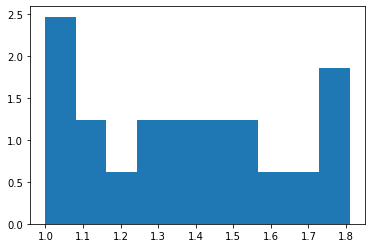

In [85]:
plt.hist(df['gap_ratio'], density=True)

# density:  True garantees that the area is 1 (such that hist approximates a 
#                 probability densitplt.hist(x)y function)

However, the sequence of bins is chosen automatically by `matplotlib` and may change from an experiment to another.

We need instead to describe all the experiments with a uniform set of features => The sequence of bins must be the same for all the experiments.

To do so:
* Open all files
* Take the min and max gap from all the experiments
* Divide the [min,max] interval uniformly

In [0]:
def get_all_csv_files(folder):
  """
  Credits to https://perials.com/getting-csv-files-directory-subdirectories-using-python/

  Returns all the csv files within the folder, and all subfolders
  """
  import os
  from glob import glob
  PATH = "/home/someuser/projects/someproject"
  EXT = "*.csv"
  all_csv_files = [file
                  for path, subdir, files in os.walk(folder)
                  for file in glob(os.path.join(path, "*.csv"))]
  return all_csv_files

To avoid data leaks, we compute the max and the min on the training set only.

In [87]:
train_files = get_all_csv_files('BandwidthEstimationTraces/training')
print('Found ', len(train_files), ' training files' )

Found  1100  training files


Find the min and max

In [88]:
min_gap = float('inf')
max_gap = 0

for filename in train_files:
      df = pd.read_csv(filename)
      df.columns=['gap_ratio', 'timestamp']
      trace_min = min( df['gap_ratio'] )
      trace_max = max( df['gap_ratio'] )
      min_gap = min ( [ min_gap, trace_min ] )
      max_gap = max ( [ max_gap, trace_max ] )

print('min_gap:', min_gap, ' max_gap:',max_gap)

min_gap: 0.95975  max_gap: 2.318


Let's create the bins that we will use for all experiments

In [89]:
N = 8 # num of bins

bin_size = (max_gap-min_gap)/N 
bins = [min_gap + i * bin_size for i in range(0, N+1)]
bins

[0.95975,
 1.1295312499999999,
 1.2993125,
 1.4690937499999999,
 1.638875,
 1.8086562499999999,
 1.9784375,
 2.14821875,
 2.318]

Just as a visual check, let's plot again the previous histogram with these new bins

[1.76697957 0.88348978 1.17798638 0.88348978 0.88348978 0.29449659
 0.         0.        ]


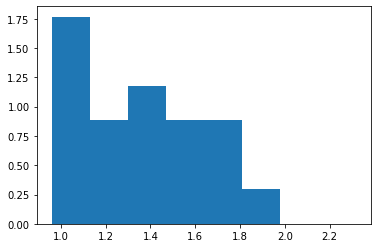

In [90]:
filename = "BandwidthEstimationTraces/training/SingleLinkCapacity100/75_et_100_C_5_delta/75_et_100_C_5_delta_33.csv"
df = pd.read_csv(filename)
df.columns=['gap_ratio', 'timestamp']
hist_values, bins, bars = plt.hist( df['gap_ratio'], density=True, bins=bins)
print(hist_values )

Let's obtain the histogram for all the experiments. For each experiment, we construct a feature vector:

  `[bin1_freq, bin2_freq, ...., binN_freq]`

and a label `avail_bandwidth`.

We write these operations in a function `construct_dataset` that we will then use for the training and the test dataset.

This is to avoid **copied and pasted code**, which are error prone.

In [0]:
def process_file(filename, bins):
      """
      For the connection described in filename, it
      returns a feature vector and the available bandwidth
      """
      df = pd.read_csv(filename)

      # Observe that for each experiment, the available bandwidth corresponds 
      # to the name of the second column
      avail_band = df.columns[1]


      df.columns=['gap_ratio', 'timestamp']

      histogram_values, bins, bars = plt.hist( df['gap_ratio'], density=True, 
                                              bins=bins)

      return histogram_values, avail_band



def construct_dataset(files, bins):
  """
  Build an X,y from the files
  """

  X = np.empty((0,N), int)
  label = []

  for filename in files:
      histogram_values, avail_band = process_file(filename, bins)

      X = np.vstack(( X, histogram_values) )
      label.append(avail_band)

  return X,label

Found  1000  test files


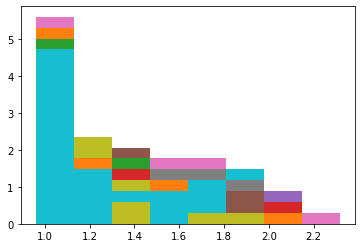

In [92]:
X_train_raw, label_train_raw = construct_dataset(train_files, bins)

test_files = get_all_csv_files('BandwidthEstimationTraces/testing')
print ('Found ', len(test_files), ' test files'  )

X_test, label_test = construct_dataset(test_files, bins)

In [93]:
print('X_train\n', X_train_raw[0:6, :] )
print('\n\nlabel_train\n',label_train_raw )

X_train
 [[2.94496595 1.17798638 1.17798638 0.58899319 0.         0.
  0.         0.        ]
 [3.23946254 0.58899319 0.88348978 0.29449659 0.58899319 0.29449659
  0.         0.        ]
 [3.23946254 0.88348978 0.29449659 0.58899319 0.58899319 0.29449659
  0.         0.        ]
 [3.23946254 0.58899319 0.58899319 0.88348978 0.29449659 0.29449659
  0.         0.        ]
 [2.94496595 1.17798638 0.58899319 0.58899319 0.58899319 0.
  0.         0.        ]
 [2.94496595 1.17798638 0.58899319 0.58899319 0.29449659 0.29449659
  0.         0.        ]]


label_train
 ['25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', '25', 

### Class imbalance

Let's check for class imbalance

In [94]:
Counter(label_train_raw)

Counter({'12.5': 100, '25': 400, '37.5': 100, '50': 400, '75': 100})

Correct using Synthetic Minority Over-Sampling Technique (SMOTE) (see `03.classification.ipynb`)

In [95]:
smote = SMOTE()
X_train, label_train = smote.fit_sample(X_train_raw, label_train_raw)

Counter(label_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Counter({'12.5': 400, '25': 400, '37.5': 400, '50': 400, '75': 400})

### Scaling
With NN is important to **scale** the dataset

In [96]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print('X_train scaled\n', X_train[0:6, :] )

X_train scaled
 [[0.46666667 0.5        0.57142857 0.33333333 0.         0.
  0.         0.        ]
 [0.53333333 0.25       0.42857143 0.16666667 0.33333333 0.2
  0.         0.        ]
 [0.53333333 0.375      0.14285714 0.33333333 0.33333333 0.2
  0.         0.        ]
 [0.53333333 0.25       0.28571429 0.5        0.16666667 0.2
  0.         0.        ]
 [0.46666667 0.5        0.28571429 0.33333333 0.33333333 0.
  0.         0.        ]
 [0.46666667 0.5        0.28571429 0.33333333 0.16666667 0.2
  0.         0.        ]]


### One-hot encoding
**One-hot encode** the target

In [97]:
# OneHotEncoder works best with dataframes. Let's convert our y lists to 
# dataframes
label_train_df = pd.DataFrame({'label':label_train})
label_test_df = pd.DataFrame({'label':label_test})

label_train_df

,label
0,25
1,25
2,25
3,25
4,25
...,...
1995,75
1996,75
1997,75
1998,75


In [98]:
one_hot_encoder = ce.OneHotEncoder(cols=['label'], use_cat_names='True')
one_hot_encoder.fit(label_train_df)
y_train = one_hot_encoder.transform(label_train_df)
y_test  = one_hot_encoder.transform(label_test_df)

print('y_train', y_train)

num_of_classes = y_train.shape[1]
class_names = y_train.columns
print('There are ', num_of_classes, ' classes:', class_names)

y_train       label_25  label_50  label_75  label_12.5  label_37.5
0            1         0         0           0           0
1            1         0         0           0           0
2            1         0         0           0           0
3            1         0         0           0           0
4            1         0         0           0           0
...        ...       ...       ...         ...         ...
1995         0         0         1           0           0
1996         0         0         1           0           0
1997         0         0         1           0           0
1998         0         0         1           0           0
1999         0         0         1           0           0

[2000 rows x 5 columns]
There are  5  classes: Index(['label_25', 'label_50', 'label_75', 'label_12.5', 'label_37.5'], dtype='object')


# Build a NN model

To train faster, change the runtime to GPU.

Now, let's build a NN architecture. The size of each sample is:

In [99]:
sample_size = X_train.shape[1]
print('The sample size is ', sample_size, 
      ', which should correspond to the number of bins ', N)

The sample size is  8 , which should correspond to the number of bins  8


Let's fix the learning rate

In [0]:
learn_rate = 0.01

Let's write a function to build a model. We need to:
* Define the architecture
* Compile it, i.e., decide the loss function to minimize, the optimization function and the metrics to show

In [0]:
def build_model():
  # Reproducibility: to ensure every time we generate a model, its weights are 
  #     always initialized in the same way
  # To know more: 
  #       https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
  np.random.seed(6)
  tf.random.set_seed(4)



  model = Sequential([
    Dense(200, input_dim=sample_size, activation='relu' ),
    Dense(50, input_dim=sample_size, activation='relu' ),
    Dense(30, input_dim=sample_size, activation='relu' ),
    Dense(15, input_dim=sample_size, activation='relu' ),
    Dense(8, input_dim=sample_size, activation='relu' ),
    Dense(num_of_classes, activation="softmax")
  ])
  # The first layer has 4 neurons and take 8 input values.
  # In the first layer, you always need to specify the input_dim
  #
  # Note that each layer adds implicitly a bias term (we do not need to care about 
  # it)
  #
  # The last layer is a softmax, since we are doing classification




  model.compile(loss="categorical_crossentropy", 
              optimizer=keras.optimizers.SGD(lr=learn_rate) ,
              metrics=['accuracy'])

  return model

See Ch.10 of [Ge19] to know more about these hyper-parameters.

Loss function:
* `categorical_crossentropy` is the cross-entropy as we defined in the slides
* In binary classification then use `sigmoid` activation function in the output layer instead of the `softmax` and `binary_crossentropy` loss.

Optimizer:
* We are using Stochastic Gradient Descent with learning rate $\eta=$ `learn_rate`

Metrics:
* We are asking Keras to show at each epoch the accuracy. Note that the accuracy value is ignored during training. This metric is just visualized

Let's build a model and print its description

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 200)               1800      
_________________________________________________________________
dense_13 (Dense)             (None, 50)                10050     
_________________________________________________________________
dense_14 (Dense)             (None, 30)                1530      
_________________________________________________________________
dense_15 (Dense)             (None, 15)                465       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 128       
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 45        
Total params: 14,018
Trainable params: 14,018
Non-trainable params: 0
__________________________________________________

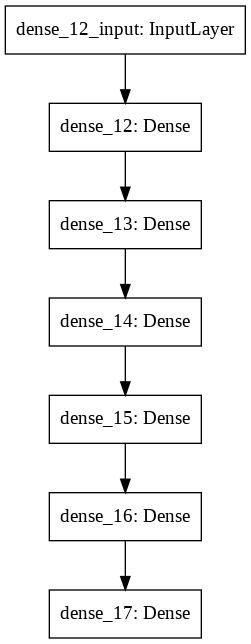

In [105]:
model = build_model()
model.summary()
plot_model(model)




This network is probably too big with respect to the small amount of data. However, nobody can tell us, until we see the training results.

**Always experiment with NNs of different sizes**

# Training

To train faster, change the runtime to GPU.

In [106]:
history = model.fit(X_train, y_train, epochs=10, validation_split=0.2)


Epoch 1/10
50/50 [==============================] - 0s 6ms/step - loss: 1.5863 - accuracy: 0.2744 - val_loss: 1.6384 - val_accuracy: 0.0000e+00
Epoch 2/10
50/50 [==============================] - 0s 3ms/step - loss: 1.5434 - accuracy: 0.3006 - val_loss: 1.6766 - val_accuracy: 0.0000e+00
Epoch 3/10
50/50 [==============================] - 0s 3ms/step - loss: 1.5045 - accuracy: 0.3031 - val_loss: 1.7173 - val_accuracy: 0.0000e+00
Epoch 4/10
50/50 [==============================] - 0s 3ms/step - loss: 1.4657 - accuracy: 0.3800 - val_loss: 1.7669 - val_accuracy: 0.0000e+00
Epoch 5/10
50/50 [==============================] - 0s 3ms/step - loss: 1.4260 - accuracy: 0.5169 - val_loss: 1.8169 - val_accuracy: 0.0000e+00
Epoch 6/10
50/50 [==============================] - 0s 3ms/step - loss: 1.3852 - accuracy: 0.5244 - val_loss: 1.8755 - val_accuracy: 0.0000e+00
Epoch 7/10
50/50 [==============================] - 0s 3ms/step - loss: 1.3466 - accuracy: 0.5375 - val_loss: 1.9296 - val_accuracy: 0.0

We divide the training set in two subsets:
* The training subset
* The validation subset 

Keras:
* Minimizes the loss on the training subset
* The validation subset is ignored => No impact on training
* The validation subset is just used to check overfitting:
    * If validation loss starts to increase


In [107]:
print(label_train)

['25' '25' '25' ... '75' '75' '75']



**Note** Keras divides the trainining set in two consecutive parts 

==> Need to shuffle data first

_Attention_ `model.fit(..)` has a parameter `shuffle`, but it still divides training and validation subset consecutively, just it shuffles the training subset.


In [0]:
X_train, y_train, label_train = shuffle(X_train, y_train,label_train, 
                                        random_state=3)

In [109]:
print(label_train)

['12.5' '37.5' '12.5' ... '12.5' '37.5' '75']


We can add some useful operations to training

In [0]:
def train_model(nn_file, X_tr, y_tr, epochs, overwrite=False):
  """
  nn_file:  Before training, the model contained in this file will be loaded
            After training, the resulting model will be written in this file

  
  overwrite: If true, the model will be built and trained from scratch
  """
  
  ##################
  #### CALLBACKS ###
  ##################
  # These functions are called at every epoch
  plot_cb = PlotLossesKeras()  # Plots the loss
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history
                # see https://theailearner.com/2019/07/23/keras-callbacks-csvlogger/



  if overwrite==True:
    os.remove(nn_file)
    os.remove(nn_file+'.csv')


  if not isfile(nn_file):
    model = build_model()
  else:
    model = load_model(nn_file)

  history = model.fit(X_tr, y_tr, epochs=epochs, 
                      callbacks = [plot_cb, checkpoint_cb, logger_cb], 
                      validation_split=0.2 )

  return model

In [111]:
nn_file = my_path + 'nn1.h5'

model = train_model(nn_file, X_train, y_train, epochs=20)

AttributeError: ignored

In [0]:
pd.read_csv(nn_file+'.csv').head()

Write a function to plot the training history

In [0]:
def plot_train_hist(csv_hist_file):
  hist_df = pd.read_csv(csv_hist_file)
  hist_df[['acc', 'loss', 'val_acc', 'val_loss']].plot()

In [0]:
plot_train_hist(nn_file+'.csv')

Let's continue training the same model

In [0]:
model = train_model(nn_file, X_train, y_train, epochs=30)

In [0]:
plot_train_hist(nn_file+'.csv')

Observe that we have the entire history: the previous training and the latter toghether

Let's train the model with more epochs

The following is just a picture showing the results of continuing training.

![alt text](https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/04.neural_networks/img/continuing_training.png)

Note that it seems validation loss is very instable. Don't worry, this is just the effect of zooming!

Let's plot the entire training history.

In [0]:
plot_train_hist(nn_file+'.csv')

* The training loss stabilized ==> we can assume we have converged

# Prediction

Let's use the model for prediction. With next lines you get the probability of each sample being in a class and the predicted class (the one with the highest probability)

In [0]:
model = load_model(nn_file)

In [0]:
y_proba = model.predict(X_test)
print( 'y_proba\n', y_proba)

pred_label = model.predict_classes(X_test)
print( 'pred_label\n', pred_label )

The best metric is the confusion matrix

In [0]:
y_test.values

We need to convert one-hot-encoded values to numerical labels

In [0]:
true_label = np.argmax(y_test.values, axis=1)
true_label

In [0]:
plot_conf_mat(true_label, pred_label, np.array(class_names) )

Some class does not appear in the matrix ==> no such class in the test set nor among the predictions.

In [0]:
unique_labels(true_label, pred_label)

If there are `nan`, it means that there is a label that does not appear in the test set but it is predicted by our model.

We still need to improve. You can play with hyper-parameters (see slides):
* Try simpler architectures
* Try more complex architectures
* Regularize
* Change the batch size (default in `model.fit(..)` is 32)
* Change the optimizer
* Change the activation functions

# Limitation of the work

* Only a finite set of available bandwidth values are used (25, 50, 75 Mbps). In reality, any value can occur => Need to extend the test and validation test with random bandwidth values.

# Regression

To perform regression with neural network, you do the same things, just change the last layer: instead of `softmax`, it is just `Dense(1)` (see pagg. 307-308 of [Ge19])

# References

* [Ge19] Geron, Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2019, O'Reilly
* [KhConf19] Khangura, S. K. (2019). Neural Network-based Available Bandwidth Estimation from TCP Sender-side Measurements. In IEEE/IFIP PEMWN.
* [KhThesis19] Khangura, S. K. (2019). Machine Learning-based Available Bandwidth Estimation. Leibniz University.